In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from scipy.stats import norm 
import pandas as pd 

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [4]:
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

DATA_FOLDER = 'O:/Dataset/Large-scale-CelebFaces-Dataset/Anno'
IMAGE_FOLDER = 'o:/Dataset/Large-scale-CelebFaces-Dataset/Img/training/'

In [58]:
INPUT_DIM = (128,128,3)
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.txt'), sep=r'\s{1,}')

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [59]:
att.reset_index(inplace=True)
att['image_id'] = att['index']
att = att.drop('index', axis=1)
att.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,image_id
0,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,000001.jpg
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,000002.jpg
2,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,000003.jpg
3,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,000004.jpg
4,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,000005.jpg


In [60]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

Found 202599 validated image filenames.


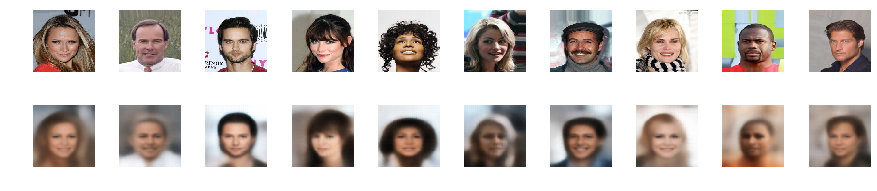

In [61]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

W0610 01:04:01.429725 13544 deprecation.py:323] From <ipython-input-62-74f5093e0ca3>:1: Model.predict_generator (from tensorflow.python.keras.engine.training_v1) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.predict, which supports generators.


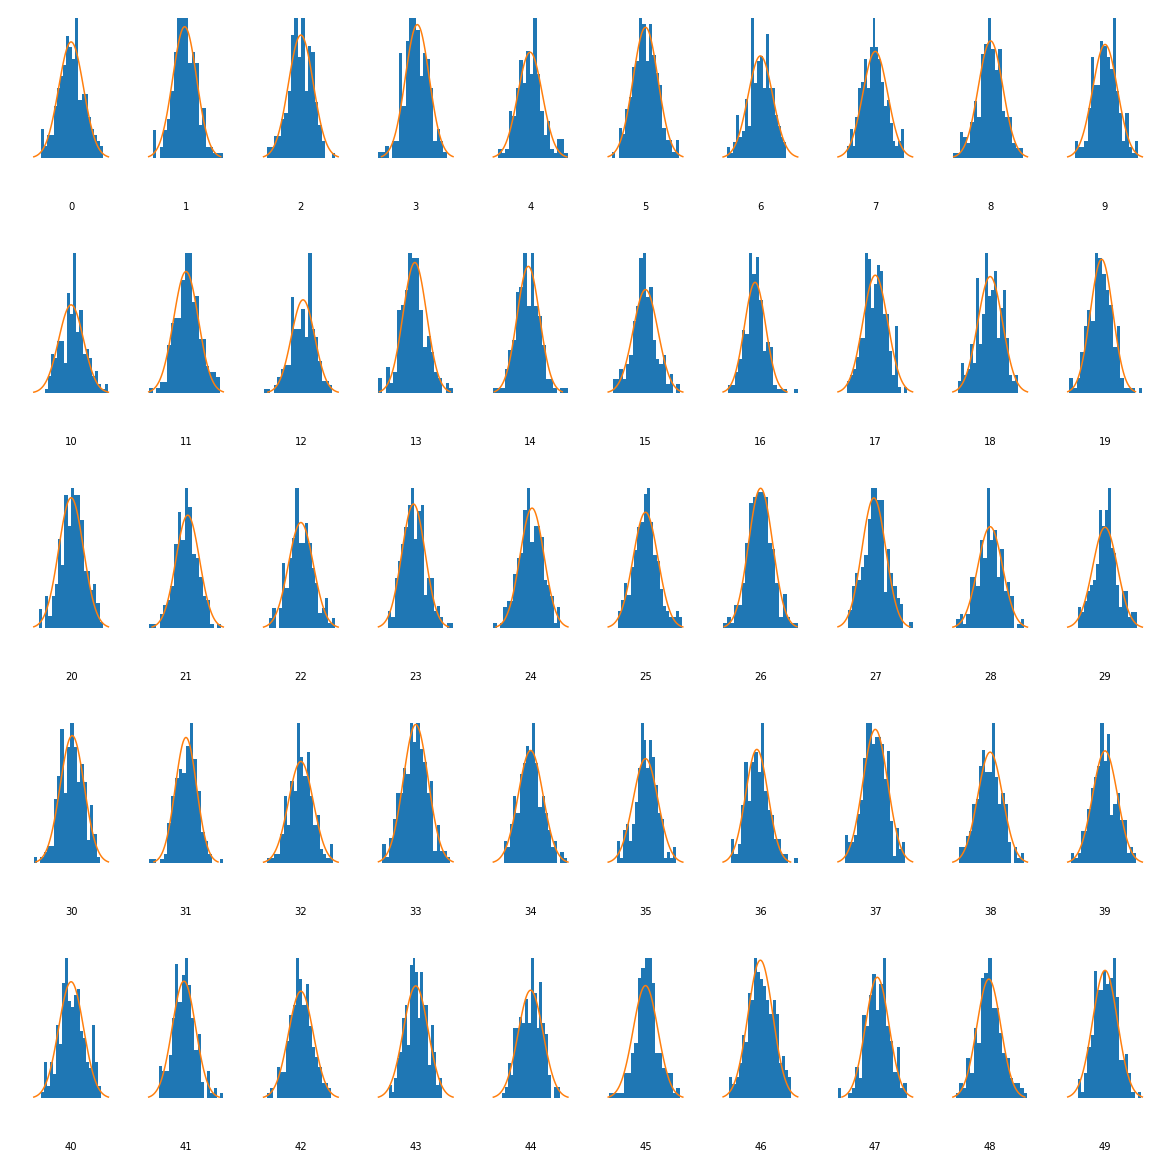

In [62]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

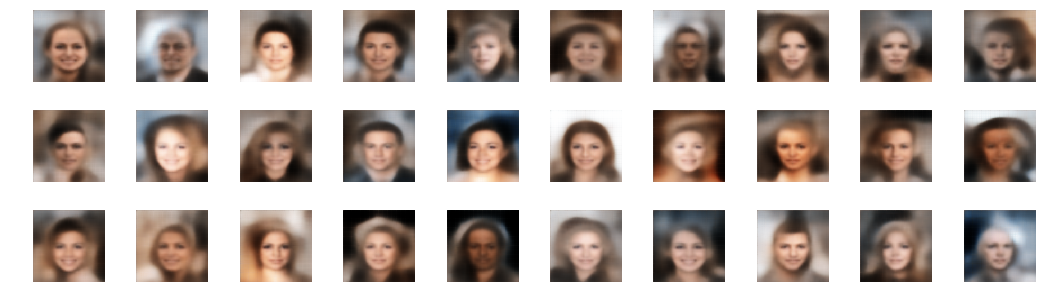

In [67]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [69]:

def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):
        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [70]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

In [71]:

BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
259    : 1.1    : 0.999    : 1.592    : 1.592
497    : 0.592    : 0.711    : 1.267    : -0.325
747    : 0.357    : 0.344    : 1.218    : -0.049
990    : 0.251    : 0.272    : 1.122    : -0.096
1263    : 0.198    : 0.192    : 1.105    : -0.017
1542    : 0.164    : 0.149    : 1.084    : -0.021
1795    : 0.128    : 0.142    : 1.06    : -0.025
2049    : 0.106    : 0.129    : 1.041    : -0.019
2296    : 0.102    : 0.106    : 1.025    : -0.016
2541    : 0.091    : 0.093    : 1.012    : -0.013
2791    : 0.079    : 0.082    : 1.007    : -0.005
3049    : 0.074    : 0.075    : 0.995    : -0.012
3306    : 0.068    : 0.072    : 0.999    : 0.003
3565    : 0.064    : 0.07    : 0.993    : -0.006
3810    : 0.06    : 0.06    : 0.986    : -0.007
4060    : 0.056    : 0.055    : 0.991    : 0.005
4306    : 0.054    : 0.056    : 0.987    : -0.004
4571    : 0.052    : 0.053    : 0.981    : -0.007
482

In [72]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
31    : 2.866    : 0.765    : 2.999    : 2.999
69    : 1.959    : 0.44    : 2.345    : -0.654
94    : 0.907    : 0.291    : 2.266    : -0.079
125    : 0.776    : 0.191    : 2.069    : -0.197
162    : 0.617    : 0.145    : 1.98    : -0.088
200    : 0.5    : 0.106    : 1.963    : -0.017
226    : 0.346    : 0.099    : 1.892    : -0.07
248    : 0.255    : 0.085    : 1.856    : -0.037
277    : 0.288    : 0.074    : 1.838    : -0.018
308    : 0.273    : 0.073    : 1.804    : -0.034
345    : 0.259    : 0.073    : 1.743    : -0.061
380    : 0.246    : 0.059    : 1.761    : 0.018
414    : 0.212    : 0.055    : 1.714    : -0.048
456    : 0.212    : 0.047    : 1.7    : -0.014
494    : 0.189    : 0.044    : 1.725    : 0.026
528    : 0.163    : 0.043    : 1.726    : 0.001
553    : 0.129    : 0.036    : 1.724    : -0.002
592    : 0.148    : 0.037    : 1.689    : -0.035
624    : 0.133    : 0.

In [73]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
70    : 2.103    : 0.741    : 2.268    : 2.268
154    : 1.104    : 0.477    : 1.969    : -0.299
232    : 0.72    : 0.274    : 1.786    : -0.183
294    : 0.398    : 0.203    : 1.753    : -0.034
367    : 0.366    : 0.143    : 1.674    : -0.079
446    : 0.289    : 0.122    : 1.671    : -0.003
532    : 0.262    : 0.104    : 1.678    : 0.007
606    : 0.214    : 0.091    : 1.676    : -0.002
676    : 0.186    : 0.08    : 1.647    : -0.029
744    : 0.154    : 0.071    : 1.636    : -0.011
820    : 0.153    : 0.061    : 1.634    : -0.002
911    : 0.153    : 0.066    : 1.624    : -0.01
1005    : 0.139    : 0.055    : 1.623    : -0.001
1087    : 0.12    : 0.05    : 1.617    : -0.006
1165    : 0.106    : 0.049    : 1.603    : -0.014
1237    : 0.1    : 0.045    : 1.602    : -0.001
1301    : 0.082    : 0.041    : 1.592    : -0.01
1372    : 0.09    : 0.036    : 1.575    : -0.017
1447    : 0.08

Eyeglasses Vector


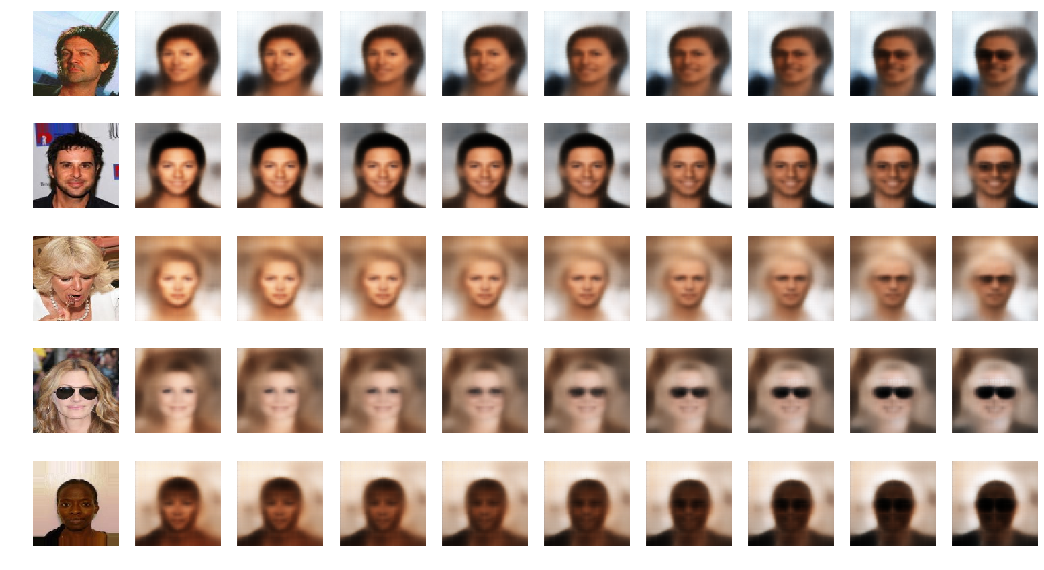

In [74]:

# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [75]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


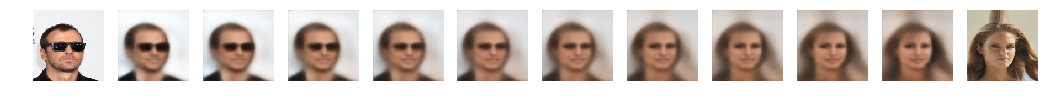

In [76]:

start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


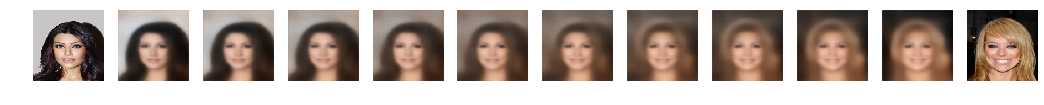

In [77]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


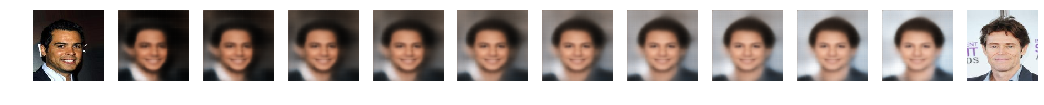

In [78]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)